In [1]:
GUI = True
from tqdm import tqdm as t

tqdm = t if GUI else lambda x: x

In [2]:
# Embedding definition

from torchtext.vocab import GloVe, FastText
vectors = GloVe(name='6B', dim=300)
# vectors = FastText(language='en')



/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [3]:
# Data preprocessing
# train-valid-test splits

import pandas as pd
import mapply
mapply.init(n_workers=20, progressbar=GUI)

clear = pd.read_feather('../data/lyrics_cleaned.feather')
clear = clear[clear['tag'] != 'misc']

clear['TAG'] = clear['tag']

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
oh = OneHotEncoder()
clear['genre'] = le.fit_transform(clear['TAG'])
clear['genre'] = oh.fit_transform(clear['genre'].values.reshape(-1, 1)).toarray().tolist()

ds = clear[['tokens', 'genre']]

from sklearn.model_selection import train_test_split

dev, test = train_test_split(ds, test_size=0.2, stratify=ds['genre'], random_state=0)
train, val = train_test_split(dev, test_size=0.2, stratify=dev['genre'], random_state=0)

/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# PD Dataframes -> Pytorch DataLoader

import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MAX_TOKENS = 150

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def vectorize(batch):
  X, y = list(zip(*batch))
  X_tensor = [vectors.get_vecs_by_tokens(x[:MAX_TOKENS].tolist(), lower_case_backup=True) for x in X]
  X_tensor = pad_sequence(X_tensor, batch_first=True)
  y_tensor = torch.tensor(y)
  X_tensor = X_tensor.to(DEVICE)
  y_tensor = y_tensor.to(DEVICE)
  return X_tensor, y_tensor

train_tensor = DataLoader((train.values), batch_size=32, shuffle=True, collate_fn=vectorize)
val_tensor = DataLoader((val.values), batch_size=32, shuffle=True, collate_fn=vectorize)
test_tensor = DataLoader((test.values), batch_size=32, shuffle=True, collate_fn=vectorize)

In [5]:
# Model definition + helper train - eval functions

from torch.nn import GRU, CrossEntropyLoss

EMBED_DIM = vectors['unk'].shape[0]
N_CLASSES = len(clear.iloc[0]['genre'])

class RNN(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size, gru_layers=1, dropout=0.2):
    super(RNN, self).__init__()
    self.n_layers = gru_layers
    self.hidden_size = hidden_size
    self.gru = GRU(input_size, hidden_size, num_layers=self.n_layers, batch_first=True, dropout=dropout)
    self.mp = torch.nn.MaxPool1d(MAX_TOKENS)
    self.fc = torch.nn.Linear(hidden_size, output_size)
    self.softmax = torch.nn.Softmax(dim=1)
    
  def forward(self, x):
    h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(DEVICE)
    output, _ = self.gru(x, h0)
    # output = output[:, -1, :]                           # last hidden state
    output = self.mp(output.permute(0, 2, 1))[:, :, -1] # max pooling of all hidden states
    fc = self.fc(output)
    sm = self.softmax(fc)
    return sm
  
model = RNN(EMBED_DIM, 1024, N_CLASSES, 10).to(DEVICE)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

from sklearn.metrics import accuracy_score

STEPS_FREQ = 50
STEPS = 0

def train_epoch(model, criterion, optimizer, train_tensor, writer = None):
  global STEPS
  model.train()
  total_loss = 0
  total_acc = 0
  for X, y in train_tensor:
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    this_loss = loss.item()
    this_acc = accuracy_score(y.argmax(1).cpu().numpy(), y_pred.argmax(1).cpu().numpy())
    if writer:
      if STEPS % STEPS_FREQ == 0:
        writer.add_scalar("train/loss", this_loss, STEPS)
        writer.add_scalar("train/accuracy", this_acc, STEPS)
    total_loss += this_loss
    total_acc += this_acc
    STEPS += 1
  return total_loss / len(train_tensor), total_acc / len(train_tensor)

EVAL_STEPS = 0

def eval_epoch(model, criterion, val_tensor, writer = None):
  global EVAL_STEPS
  model.eval()
  total_loss = 0
  total_acc = 0
  with torch.no_grad():
    for X, y in val_tensor:
      y_pred = model(X)
      loss = criterion(y_pred, y)
      total_loss += loss.item()
      total_acc += accuracy_score(y.argmax(1).cpu().numpy(), y_pred.argmax(1).cpu().numpy())
  this_loss = total_loss / len(val_tensor)
  this_acc = total_acc / len(val_tensor)
  if writer:
    writer.add_scalar("eval/loss", this_loss, EVAL_STEPS)
    writer.add_scalar("eval/accuracy", this_acc, EVAL_STEPS)
  EVAL_STEPS += 1
  return this_loss, this_acc 

In [6]:
%load_ext tensorboard

In [7]:
# Optuna objective definition + parameter search

import optuna
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

MODEL_NAME = 'RNN_GRU'
MODEL_DIR = '../NAS/' + MODEL_NAME + '/' + str(datetime.now())

%tensorboard --logdir '{MODEL_DIR}'/runs

RUN = 0

train_eval, _ = train_test_split(train, train_size=0.2, random_state=0, stratify=train['genre'])
val_eval, _ = train_test_split(val, train_size=0.2, random_state=0, stratify=val['genre'])

train_tensor = DataLoader((train_eval.values), batch_size=50, shuffle=True, collate_fn=vectorize)
val_tensor = DataLoader((val_eval.values), batch_size=50, shuffle=True, collate_fn=vectorize)
test_tensor = DataLoader((test.values), batch_size=50, shuffle=True, collate_fn=vectorize)

def objective(trial: optuna.trial.BaseTrial):
  global STEPS
  global EVAL_STEPS
  global RUN
  STEPS = 0
  EVAL_STEPS = 0

  writer = SummaryWriter(
    log_dir=f'{MODEL_DIR}/runs/{RUN:03d}'
  )

  EPOCHS = 5
  LR = trial.suggest_float('learning_rate', 1e-6, 1e-1, log=True)
  UNITS = trial.suggest_int('layer_units', 256, 1024, log=True)
  LAYERS = trial.suggest_int('n_layers', 1, 7)
  DROPOUT = trial.suggest_float('dropout', 0, 0.5)

  model = RNN(EMBED_DIM, UNITS, N_CLASSES, LAYERS, DROPOUT).to(DEVICE)
  criterion = CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LR)
  for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, criterion, optimizer, tqdm(train_tensor), writer=writer)
    val_loss, val_acc = eval_epoch(model, criterion, val_tensor, writer=writer)
  RUN += 1
  return [val_loss, val_acc]

study = optuna.create_study(
  storage="sqlite:///db.sqlite3",
  study_name=MODEL_NAME,
  directions=["minimize", "maximize"],
  load_if_exists=True
)

study.optimize(objective, n_trials=20)

[I 2024-06-03 11:00:36,161] A new study created in RDB with name: RNN_GRU
100%|██████████| 29/29 [00:01<00:00, 17.22it/s]
[I 2024-06-03 11:00:42,210] Trial 0 finished with values: [1.6091755969183785, 0.20089285714285715] and parameters: {'learning_rate': 2.1692729054286937e-05, 'layer_units': 276, 'n_layers': 5, 'dropout': 0.33642865392960414}. 
100%|██████████| 29/29 [00:01<00:00, 25.61it/s]
[I 2024-06-03 11:00:46,191] Trial 1 finished with values: [1.6100056341716222, 0.20089285714285715] and parameters: {'learning_rate': 2.3836162499687994e-07, 'layer_units': 417, 'n_layers': 2, 'dropout': 0.045702708304124484}. 


100%|██████████| 18/18 [00:01<00:00, 17.17it/s]


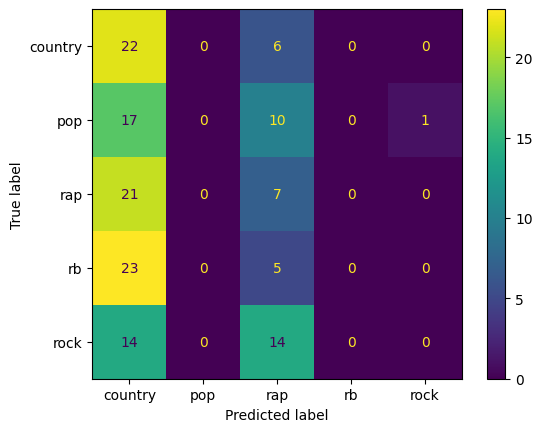

In [40]:
# Final retraining on best parameters found

best_model = study.best_trials[0]

dev_tensor = DataLoader((dev.values), batch_size=50, shuffle=True, collate_fn=vectorize)
test_tensor = DataLoader((test.values), batch_size=50, shuffle=True, collate_fn=vectorize)

params = best_model.params

global STEPS
global EVAL_STEPS
global RUN
STEPS = 0
EVAL_STEPS = 0

writer = SummaryWriter(
  log_dir=f'{MODEL_DIR}/runs/final'
)

EPOCHS = 5
LR = params['learning_rate']
UNITS = params['layer_units']
LAYERS = params['n_layers']
DROPOUT = params['dropout']

model = RNN(EMBED_DIM, UNITS, N_CLASSES, LAYERS, DROPOUT).to(DEVICE)
criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
for epoch in range(EPOCHS):
  train_loss, train_acc = train_epoch(model, criterion, optimizer, tqdm(dev_tensor), writer=writer)


y_true_list = []
y_pred_list = []

import numpy as np

with torch.no_grad():
  for X, y in test_tensor:
    y_pred = model(X).detach().cpu()
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y.detach().cpu(), axis=1)
    y_true_list += [y_true]
    y_pred_list += [y_pred]

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),
                              display_labels=le.classes_)
disp.plot()


In [45]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     country       0.23      0.79      0.35        28
         pop       0.00      0.00      0.00        28
         rap       0.17      0.25      0.20        28
          rb       0.00      0.00      0.00        28
        rock       0.00      0.00      0.00        28

    accuracy                           0.21       140
   macro avg       0.08      0.21      0.11       140
weighted avg       0.08      0.21      0.11       140



/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hlt/HLT_PROJECT/.env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
torch.save(model, f'{MODEL_DIR}/final.pt')